Osnabrück University - Machine Learning (Summer Term 2024) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Lukas Niehaus

# Exercise Sheet 04: Clustering

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, May 12, 2024**. If you need help (and Google and other resources were not enough), use the StudIP forum, contact your groups designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

# Assignment 1: Kmeans Clustering (5 points)

**a)** Perform K-means clustering to divide the following datset into 2 clusters by hand.

| x1 | x2 |x3 |
|----|----|---|
|  1 | 1  | 1 |
|  2 | 1  | 1 |
|  3 | 1  | 2 |
|  2 | 3  | 4 |
|  5 | 5  | 5 |
|  3 | 2  | 1 |

Start with the following centroids for the two clusters: $(1,1,1)$ and $(5,5,5)$.

![image](4_ex1a.jpg)
![image](4_ex1b.jpg)

**b)** $k$-mean clustering of a given dataset can result in different outcomes. Explain, at which point the algorithms is indeterministic and explain how to compare the quallity of different outcomes.

The only point in time when the algorithm is indeterministic is the first step, in which the K reference vectors are chosen randomly. After this step, every other one is determined by the datapoints and the cluster-centers (the reference vectors).
In order to compare the quality of different outcomes one can take a look at the number of points assigned to each cluster. For example should empty clusters be avoided. Another method for comparing is taking a look at a visualisation of the datapoints and assignment to clusters (if there are more than 2 dimensions, one can consider using PCA in order to reduce dimensions). Another method of comparison is looking at intra- vs inter-cluster distances. Here, intra-cluster distance should be smaller than inter-cluster distances, since then we know that the points assigned to each cluster are closer to points in their cluster than to those points in other clusters. 

**c)** The pseudocode for k-means algorithm on (ML-05, slide 27) uses as the termination condition ($\exists k \in[1,K]: \|\vec{w}_k(t)-\vec{w}_k(t-1)\|>\varepsilon$). Discuss this condition from a theoretical and practical perspective and name alternatives.

The condition tries to determine wether the assignment of the points to the clusters still changes. It does this via comparing the calculated centroid for each cluster with the centroid of that cluster in the previous step. If the chosen $\varepsilon$ is too small or even negative, the algorithm might never terminate, for the distance between two points cannot be negative. Another case is when there are datapoints which oscillate between the clusters in the final step and keep changing the centroids. If the $\varepsilon$ is too big on the other hand the termination condition might be too coarse and it might stop the clustering too early.
Alternatives are checking if the number of points assigned to each cluster still changes. This however would stop the clustering prematurely too often, since no quantitative change might occur while qualitatively (which point is assigned to which cluster) things are still changing. One could also check for every datapoint to which cluster it is assigned and stop the clustering when e.g. 98 % of the datapoints have stopped changing their assignment. This is a worse variation of our original criterion, since it needs more memory as every point has to remember their previous cluster instead of just keeping track of the centroids.

# Assignment 2: k-means Clustering (7 points)

## a) Implement k-means clustering. Plot the results for $k = 7$ and $k = 3$ in colorful scatter plots.

How could one handle situations when one or more clusters end up containing 0 elements? Handle these situtation in your code.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from scipy.spatial.distance import cdist


def assign_cluster_labels(data, centroids):
    """
    Assigns given data to nearest of given centroids, using euclidian distance.

    Args:
        data (ndarray): a numpy array of shape (n, 2), providing n
                        2-dimensional datapoints
        centroids (ndarray): vector representation of cluster centers of shape (k, 2)

    Returns:
        labels (ndarray): Numpy array containing numbers (= which centroid each point is assigned to) with the same order as the data points
                          e.g. (1,1,3,5,5,5,...)
    """

    # get the distance of each point to each centroid
    y = cdist(data, centroids, "euclidean")
    # find the centroid to which the distance is smallest for each data point individually
    labels = np.argmin(y, axis = 1)

    return labels


def calc_centroids(data, labels, k):
    """
    Calculates k new centroids according to given data points and their assigned clusters.

    Args:
        data (ndarray): a numpy array of shape (n, 2), providing n
                        2-dimensional datapoints
        labels (ndarray): Numpy array containing numbers (= which centroid each point is assigned to) with the same order as the data points
                          e.g. (1,1,3,5,5,5,...)

    Returns:
        centroids (list): vector representation of cluster centers of shape (k, 2)
    """
    # initialize empty centroid list
    centroids = []

    # for every cluster label
    for i in list(range(k)):

        # define an empty filter
        mask = []

        # go through the cluster-assignments of all datapoints
        for elem in labels:
            # if label of datapoint = current cluster number
            if elem == i:
                mask.append(True)
            # if label of datapoint \= current cluster number
            else:
                mask.append(False)

        # filter in all datapoints which were assigned to the current cluster 
        # discard the rest
        pts = data[mask]

        # compute new centroid by getting the mean
        centroid = np.mean(pts, axis = 0)

        centroids.append(centroid)

    return centroids

def kmeans(data, k=3):
    """
    Applies k-means clustering to given data.

    Args:
        data (ndarray): a numpy array of shape (n, 2), providing n
                        2-dimensional datapoints
        k (int): Number of clusters

    Returns:
        labels (ndarray): Numpy array containing numbers (= which centroid each point is assigned to) with the same order as the data points
                          e.g. (1,1,3,5,5,5,...)
        centroids(ndarray): vector representation of cluster centers of shape (k, 2)
    """

    # initialize random centroids
    centroids_old = np.random.randn(k,2)
    # create array of 0s for labels
    labels = np.zeros(len(data))
    # termination condition
    stop = False

    while stop == False:
        # assign new cluster labels
        labels = assign_cluster_labels(data, centroids_old)

        # if one of the clusters is empty (i.e. labels doesn't contain it)
        if len(set(labels)) != k:
            # figure out which cluster is empty
            for i in list(range(k)):
                if i not in set(labels):
                    # get the index of a random datapoint
                    rand_idx = random.randint(0, len(data)-1)
                    # assign this datapoint to the empty cluster (set its label to the empty cluster's)
                    labels[rand_idx] = i
       
        # get the updated centroids according to data assignment
        centroids_new = calc_centroids(data, labels, k)

        # assume we are already done (terminate)
        stop = True

        # check if we are actually done
        # for every delta of the centroids
        for elem in np.subtract(centroids_old, centroids_new):
            # if the euclidean distance of delta is large enough
            if math.sqrt(sum(i **2 for i in elem)) > 0.01:
                # new centroids become old centroids for next iteration
                centroids_old = centroids_new
                # termination condition not met
                stop = False
                # go to next iteration
                break
        
    return labels, np.array(centroids_new)

# testing
data = np.loadtxt('clusterData.txt')
kmeans(data, 3)
a=1 # stop weird notebook mechanics

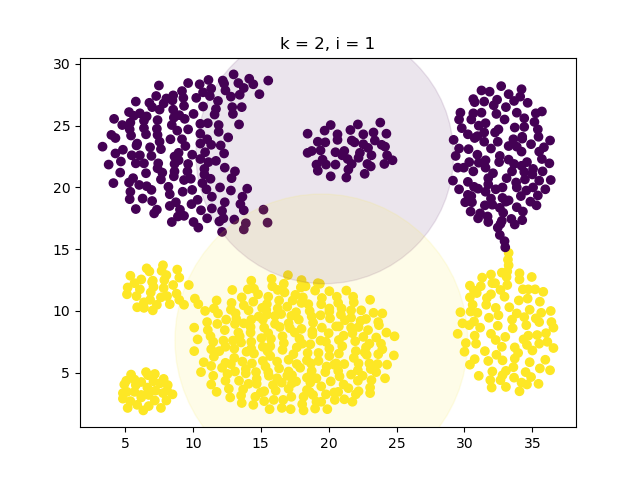

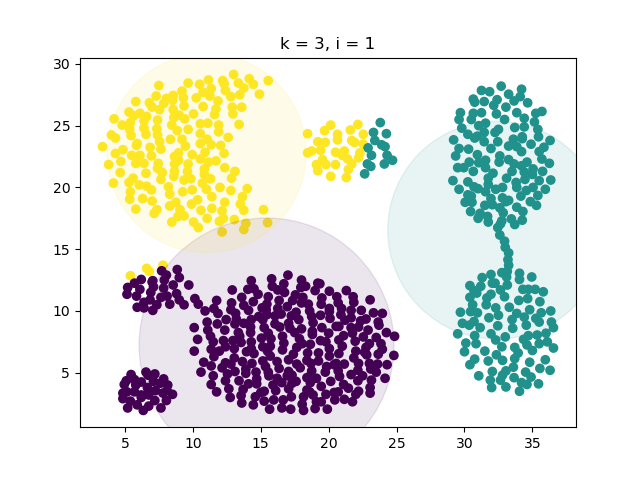

c:\Users\info\miniconda3\envs\ml\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\info\miniconda3\envs\ml\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


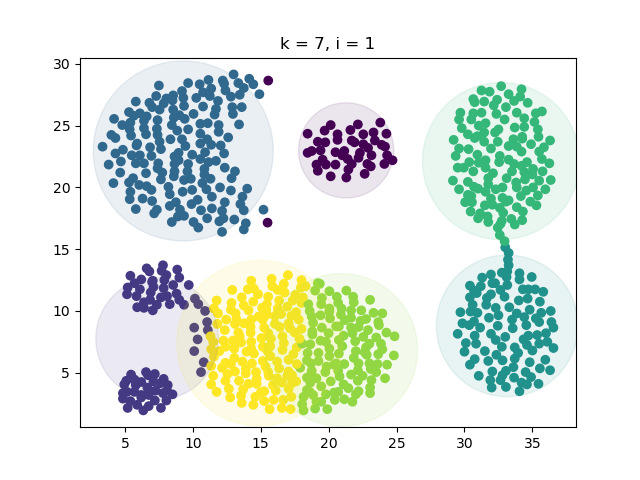

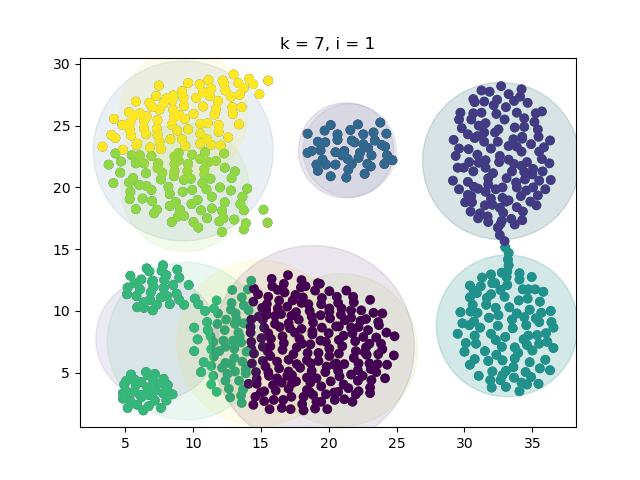

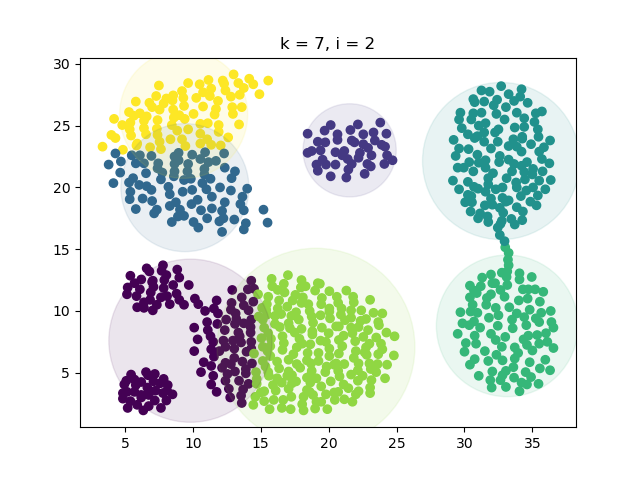

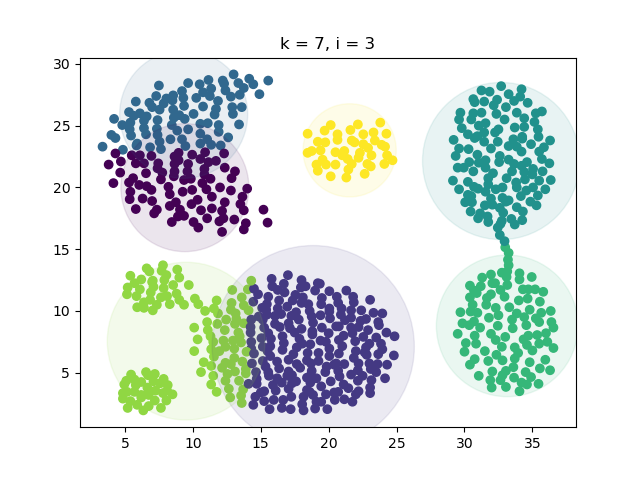

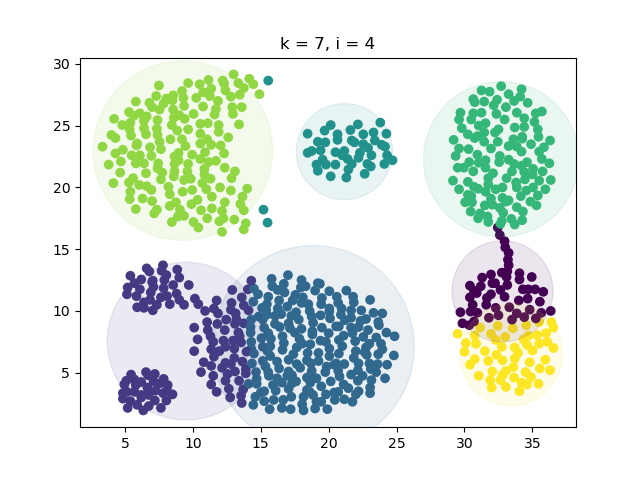

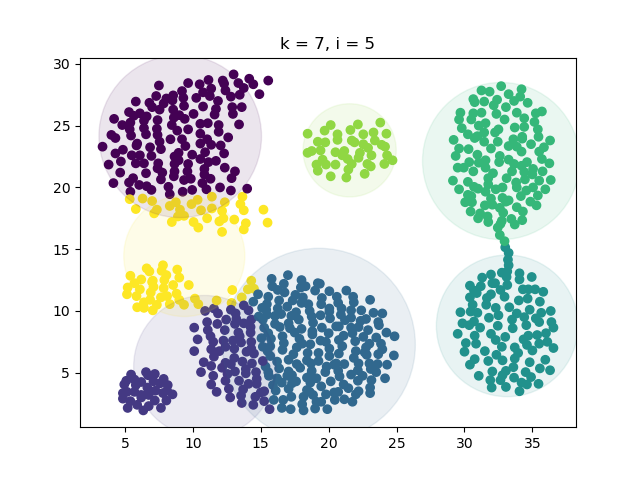

In [3]:
%matplotlib ipympl

data = np.loadtxt('clusterData.txt')

# Test experiments with a different number of clusters and different 
# number of runs here.
# You can define the number of clusters and how often k-means is called
# allowing to investigate the inlfuenece of the number of clusters and 
# of the different random cluster initializations per run.


# Experiment 1: One run with k=2
experiment_1 = ((2,1),)
# Experiment 2: One run with k=3, one run with k=7
experiment_2 = ((3,1),(7,1))
# Experiment 3: Five run with k=7
experiment_3 = ((7,5),)

# go through all experiments so we can look at all results at once
for experiment in [experiment_1, experiment_2, experiment_3]:

    for params in  experiment:
        k = params[0]
        for i in range(1, params[1]+1):
            labels, centroids = kmeans(data, k)
            
            assert isinstance(labels, np.ndarray), "'labels' should be a numpy array!"       
            assert isinstance(centroids, np.ndarray), "'centroids' should be a numpy array!"    
            assert labels.shape==(data.shape[0],), "Each data point needs a label!"
            assert centroids.shape==(k,data.shape[1]), ("k centroids with the same dimensionality "
                "as the data are needed!")
            
            kmeans_fig = plt.figure('k-means with k={}, i={}'.format(k,i))
            plt.scatter(data[:,0], data[:,1], c=labels)
            plt.scatter(centroids[:,0], centroids[:,1], 
                        c=list(set(labels)), alpha=.1, marker='o',
                        s=np.array([len(labels[labels==label]) for label in set(labels)])*100)
            plt.title('k = {}, i = {}'.format(k, i))
            kmeans_fig.canvas.draw()
            plt.show()   

## b) Why might the clustering for k=7 not look optimal? 
What happens if you run the algorithm several times?

The cluster assignments keep changing when running the algorithm multiple times. This is due to different reference vectors in the beginning. With random initialization it is hard to find optimal starting points by coincidence and with a higher k there is a greater variability (i.e. we guess more often and are subjected to randomness more often) (it is thus more sensitive to the initialization).

The assignment is not optimal since some clusters (clusters to our eye) are split up and other clusters are combined. This might also be due to the fact that some clusters are a lot bigger than others, leading to a higher intra-cluster distance compared to the inter-cluster distances.

# Assignment 3: Scipy Clustering (3 points)

The documentation of [Scikit-Learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) compares the characteristics of different cluster algorithms by showing their performance on various toy datasets. [Hierarchical](https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py) is clustering is shown in detail in a seperate notebook.
The lecture focuses on the clustering methods for agglomerative with single, complete, average and ward (ML-5 Slide: 8-12), kmeans (ML-5 Slide: 26) and gaussian mixture (ML-5 Slide: 36), which are implemented in the code below.
You can modify the random state for the dataset generation, clustering approach and number of samples to get a deeper understanding for the different clustering algorithms.
Below the code are questions about the datasets and clustering algorithms which you should answer.

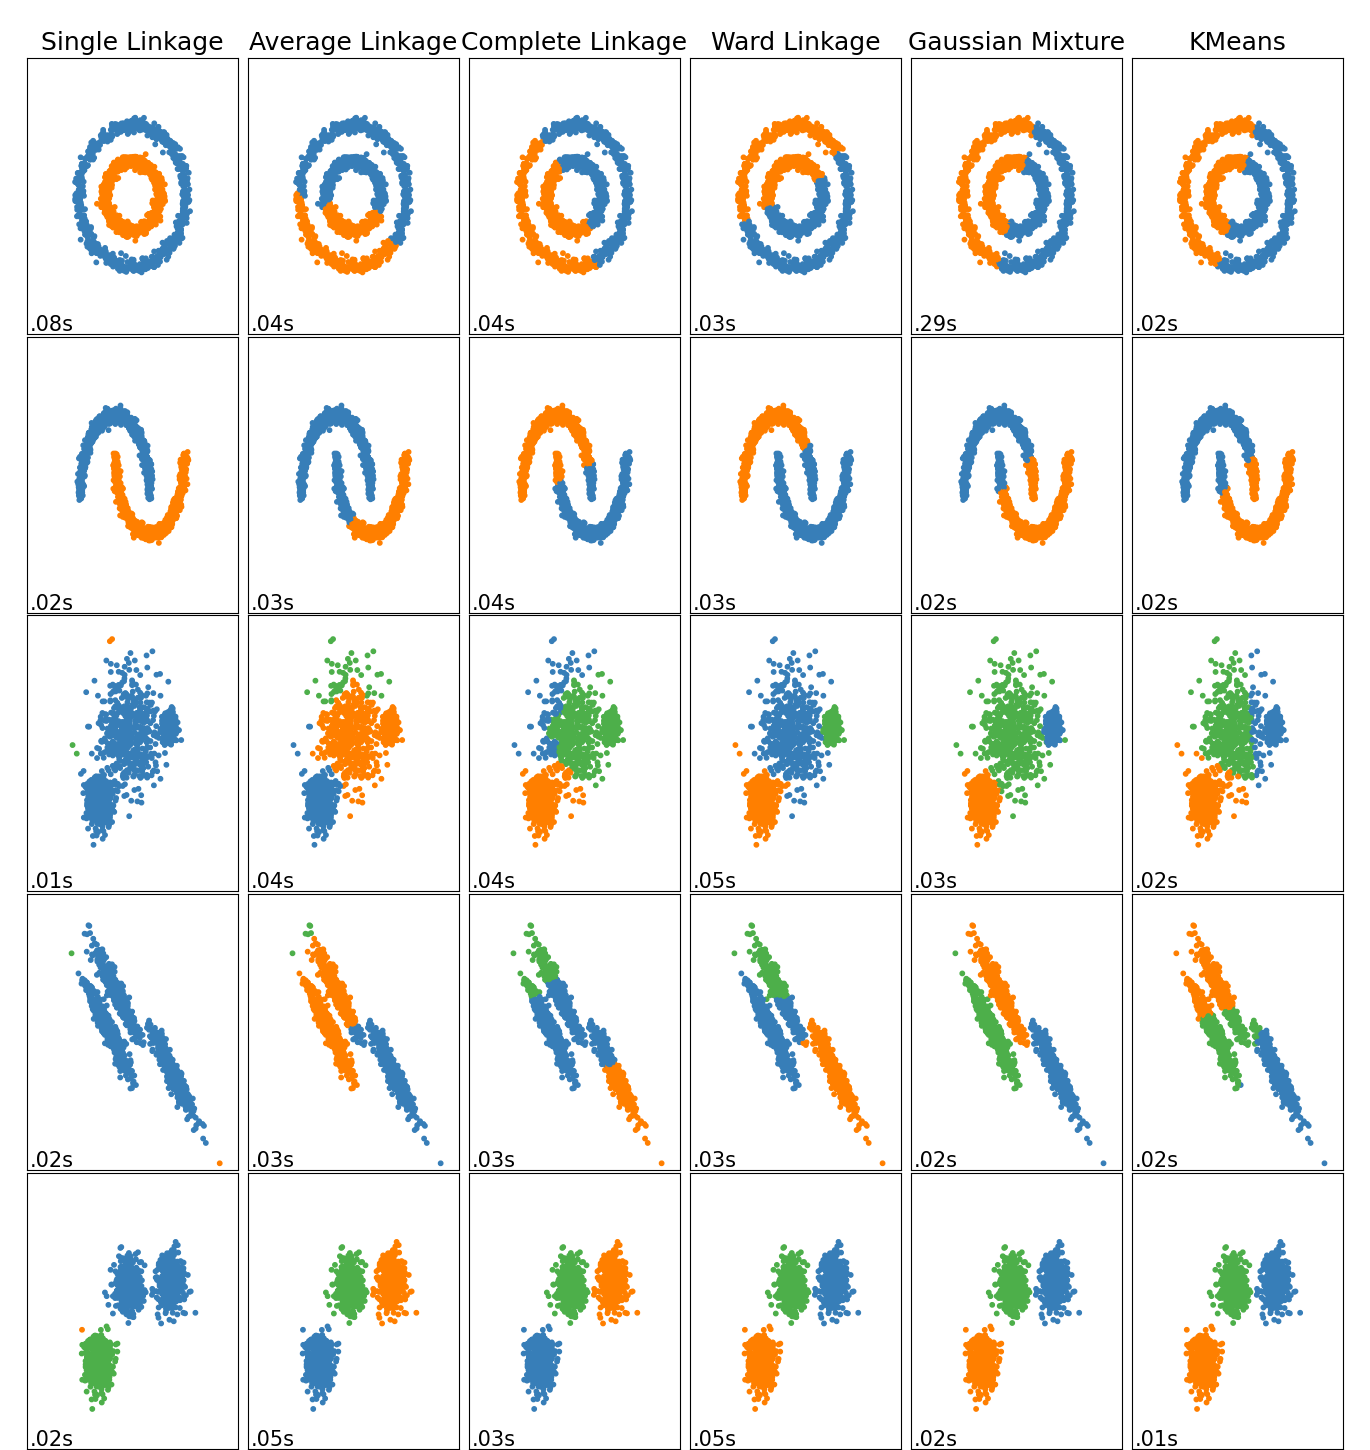

In [4]:
import time
import warnings
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

### MODIFY VALUES ###

random_state_dataset = 170
random_state_clustering = 170
n_samples = 1500

### CREATE DATASETS ###

noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=random_state_dataset
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=random_state_dataset)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=random_state_dataset)
rng = np.random.RandomState(random_state_dataset)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state_dataset)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state_dataset
)

### Start CLUSTERING ###

# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {"n_neighbors": 10, "n_clusters": 3, "random_state": random_state_clustering}

datasets = [
    (noisy_circles, {"n_clusters": 2}),
    (noisy_moons, {"n_clusters": 2}),
    (varied, {"n_neighbors": 2}),
    (aniso, {"n_neighbors": 2}),
    (blobs, {}),
    #(no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    single = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], 
        linkage="single"
    )
    average = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], 
        linkage="average"
    )
    complete = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], 
        linkage="complete"
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], 
        linkage="ward"
    )
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )
    #kmeans = cluster.MiniBatchKMeans(
    kmeans = cluster.KMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
        n_init="auto"
    )
    
    clustering_algorithms = (
        ("Single Linkage", single),
        ("Average Linkage", average),
        ("Complete Linkage", complete),
        ("Ward Linkage", ward),
        ("Gaussian Mixture", gmm),
        ("KMeans", kmeans)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-3.5, 3.5)
        plt.ylim(-3.5, 3.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.22,
            #0.50,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
            #verticalalignment="top",
        )
        plot_num += 1

plt.show()

## a) Which of the clusters obtained by the different algorithms would be seen as good for the different toy datasets and why?

- Dataset 1:
Sinle Linkage clustering \
forms 2 circles truly; (due to chaining tendency this works well); other algorithms do not manage to seperate the circles but cut through them 

- Dataset 2:
Single Linkage Clustering \
manages to follow the curved shape of the two areas; other algorithms can't do this but split them (as in dataset 1) 


- Dataset 3:
Ward Linkage, Gaussian Mixture, complete linkage \
seperates everything into 2 smaller areas and 1 larger one --> this way singleton clusters are avoided & all clusters still appear to have "reasonable" shape, density \
Gaussian mixture is 2x faster than Ward --> due to very similar results (similar quality of resuts well) in a use case scenario probably prefer Gaussian

- Dataset 4:
Gaussian Mixture \
creates 3 line shapes; assigns all datapoints in that line to the respective cluster --> other algorithms fail to ompletely do so

- Dataset 5:
Average Linkage, Complete Linkage, Ward Linkage, Gaussian Mixture, K-Means \
all of these give the exact same result; nice separation into 3 distinct non-overlapping clusters which are compact \
in terms of performance k-means and Gaussian mixture are superior (once again taking 1 - 3s quicker than other algorithms)

## b) Explain why single linkage clustering creates good results for dataset one and two, but bad results for dataset 3, 4 and 5.

-  Single Linkage tends to chaining
- helful for Dataset 1,2 (since "following a line" here resuts in the underlying shape)
- there is little noise between the clusters connecting them --> single linkage clustering can't "fall into that trap" and connect areas that shouldn't be connected

## c) Why does ward work good on dataset 3 but bad on dataset 4?

- Ward linkage concers itself w/ variance
- calculates the difference between datapoints and the cluster mean
- since the desired clusters are very stretched in dataset 4, slim but long; this is antithetical to the spherical clusters usually produced by Ward linkage clustering
- there is no agglomeration (Ballungsgebiet) really but rather the stretched line-like structures
- in dataset 3 this is not the case; here the variance approach works better

## d) explain the difference between gaussian mixture and kmeans clustering for dataset 3 and 4

- k-means struggles w/ distributions where intra-cluster distance is larger than inter cluster distance at certain points (if this happens, k-means reassigns datapoints)
- thus, for dataset 4: slim, long (high intra-variance) but close next to each other (low inter- variance) --> k-means struggles here
- same approach for dataset 3
- k-means assigns every datapoint according to the distance to the neares centroid --> no differentiations for possibly different underlying distributions
- for dataset 3: k-means "branches out" more (since these datapoints have a close distance to the centroids)
- gaussian mixture doesn't have this problem (can model different distributions for different clusters)

## e) Why do the methods for gaussian mixture and kmeans need a random state and the single, average complete and ward linkage do not require these?

- k-means, gaussian mixture need an initialization; a point to start from
- other methods will arrive at the same result no matter what you do (no need for a starting point) [hierachical clustering algorithms]
--> hierarchy is inherent in data; doesn't really matter where you start looking first
- gaussian, k-means are optimization based --> can only optimize sth if you start somewhere specific